# VARIABLE DESCRIPTIONS:
* survival:        Survival (0 = No; 1 = Yes)
* pclass:          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name:            Name
* sex:             Sex
* age:             Age
* sibsp:           Number of Siblings/Spouses Aboard
* parch:           Number of Parents/Children Aboard
* ticket:          Ticket Number
* fare:            Passenger Fare
* cabin:           Cabin
* embarked:        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from ggplot import *
plt.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

### Data Cleaner/ Feature Engineering

In [2]:
def data_filler(train_df, test_df):

    # Function to fill in Empty values for Age and Fare
    # This way the entire dataset can be used to calculate median Age
    # Only necessary columns needed for these calculations will be created. 

    # Remove Survived Column from Train DF 
    # and join the two data frames
    joined_df = pd.concat([train_df.drop(['Survived'], 1), test_df])
    
    # Add 'Title' Column
    joined_df['Title'] = joined_df['Name']
    joined_df['Title'] = joined_df['Title'].map(lambda x: x.rsplit(',')[1].rsplit('.')[0].strip())
    
    # Fill Age Based on Title
    joined_df['AgeFill'] = joined_df['Age']
    median_ages_title = np.zeros(6)
    title_fill = ['Master', 'Miss', 'Mr', 'Mrs', 'Ms', 'Dr']
    
    for idx, val in enumerate(title_fill):
        median_ages_title[idx] = np.average(joined_df[joined_df['Title'] == val]['Age'].dropna())
        joined_df.loc[ (joined_df.Age.isnull()) & (joined_df.Title == val) ,'AgeFill'] = median_ages_title[idx]

    # Fill Missing Fare (n=1) Based on Class (Pclass=3)
    joined_df['FareFill'] = joined_df['Fare']
    joined_df.loc[(joined_df.Fare.isnull()), 'FareFill'] = np.average(joined_df[joined_df['Pclass'] == 3]['Fare'].dropna())
    
    # Fill in Missing Embarked - Googled 
    joined_df['EmbarkFill'] = joined_df['Embarked']
    joined_df.loc[(joined_df.Embarked.isnull()), 'EmbarkFill'] = 'S'
    
    # Resplit Data
    train_data = joined_df[:len(train_df)]
    test_data = joined_df[len(train_df):]
    
    # Add Survived Column back to Train DF
    train_data.insert(1, 'Survived', train_df['Survived'].values)
    
    return train_data, test_data
    

In [3]:
def add_features(df):
    
    le = LabelEncoder()

    # Convert Embarked Str in Embarked Int using sklearn
    df['EmbarkedInt'] = le.fit_transform(df['EmbarkFill']).astype(np.float)

    # Convert 'Sex' Str to 'Gender' Int
    df['Gender'] = le.fit_transform(df['Sex']).astype(np.float)


    
    # Convert Title Str to Title Int
    df['Title'] = le.fit_transform(df['Title']).astype(np.float)

    # AgeIsNull: 1 = Age was NaN, 0 = Age was present
    df['AgeIsNull'] = df['Age'].isnull().astype(int)
    
    # FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    df['CabinPre'] = df['Cabin'].fillna('X').apply(lambda x: x[0])
    df['CabinInt'] = le.fit_transform(df['CabinPre']).astype(np.float)
    

#     df = df.drop(['Age', 'Name', 'Fare', 'Sex', 'Ticket', 'Cabin', \
#                   'SibSp', 'Parch', 'Embarked', 'EmbarkFill'], 1)
    
    return df

In [4]:
#Raw Data
train_df_og = pd.read_csv('data/train.csv')
test_df_og = pd.read_csv('data/test.csv')

# Fill the Missing Values
train_df_fill, test_df_fill = data_filler(train_df_og, test_df_og)


# Add Features
train_df_feat = add_features(train_df_fill)
test_df_feat = add_features(test_df_fill)

# train_df_feat.head(8)

In [5]:
# joined_df = pd.concat([train_df_fill.drop(['Survived'], 1), test_df_fill])
train_df_feat.columns.values

# ggplot(train_df_fill, aes('Title', fill='Survived')) + geom_histogram() + scale_y_continuous(limits=(0,50))

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'AgeFill',
       'FareFill', 'EmbarkFill', 'EmbarkedInt', 'Gender', 'AgeIsNull',
       'FamilySize', 'CabinPre', 'CabinInt'], dtype=object)

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

### Learner

In [33]:
## Prepare DFs for sklearn

features = ['Pclass', 'AgeFill', 'Gender', 'FareFill', 'CabinInt', 'FamilySize']

X = train_df_feat.ix[:,features].values
y = train_df_feat.ix[:, 'Survived'].values

X_test = test_df_feat.ix[:,features].values

In [181]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(y, n_folds=10, random_state=42)

plotter = []

# for n in range(30,101,10):

#     logging.info(n)


cv_accuracy_score = []

for train_index, test_index in skf:
    X_train, X_cv = X[train_index], X[test_index]
    y_train, y_cv = y[train_index], y[test_index]

    clf = RandomForestClassifier(n_estimators=70)

    clf.fit(X_train, y_train)

    pred = clf.predict(X_cv)
    
    if accuracy_score(y_cv, pred) > 0.88:
        output = clf.predict(X_test)
        results = list(zip(test_df_feat.PassengerId, output.astype(int)))
        submission = pd.DataFrame(results, columns=['PassengerId', 'Survived'])
        submission.to_csv('randomforest.csv', index=False)
    
    cv_accuracy_score.append(accuracy_score(y_cv, pred))
    

#     plotter.append((n, np.mean(cv_accuracy_score)*100)

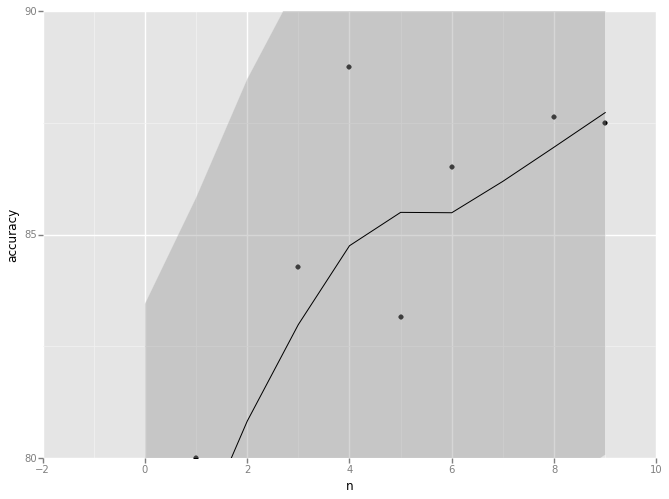

<ggplot: (288182855)>

 73.0337078652 82.1707240949 88.7640449438


In [182]:
acc = pd.DataFrame(cv_accuracy_score, columns=['accuracy']).reset_index().rename(columns={'index': 'n'})
acc.accuracy = acc.accuracy*100

# acc = pd.DataFrame(plotter, columns=['n','accuracy'])

print(ggplot(acc, aes(x='n', y='accuracy')) + geom_point() + scale_y_continuous(limits=(80, 90)) + stat_smooth())

print('\n', min(acc.accuracy), np.mean(acc.accuracy), max(acc.accuracy))

 71.9101123596 82.6076211554 87.6404494382
